In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
from firedrake import *

In [14]:
n = 600
dt = 1./n
n = 200
mesh = PeriodicIntervalMesh(n,1) # create periodic grid
x = SpatialCoordinate(mesh)[0]  # extract coordinates
c_s = Constant(1)               # speed of sound
U = Constant(0.1)              # mean flow

Q = FunctionSpace(mesh,'Lagrange',1) # function space. Functions will be approximated using second order Lagrange Polynomials
V = Q*Q                              # Create mixed functions space. Need to use due to coupled system
U_n1 = Function(V)                   # Vector containing Solutions at t+1
U_n = Function(V)                    # Vector containing Solutions at t
u_n, p_n = U_n.split() #important! don't use split(U_n) but how is this related to wence warning? See: https://github.com/firedrakeproject/firedrake/issues/1819
v = TestFunction(V)   

#c_s = 0.2
#U = 0.1
x1 = 0.25
x0 = 0.75
sigma = 0.1
k = 7.2*np.pi
S = np.asmatrix([[1,1],[1,-1]])
S_1 = np.asmatrix([[0.5,0.5],[0.5,-0.5]])
A = np.asmatrix([[U,c_s],[c_s,U]])

def p0(x,sigma=sigma):
    return exp(-x**2/sigma**2)
                 
def p1 (x,p0=p0,sigma=sigma,k=k):
    return p0(x)*cos(k*x/sigma)

def p(x,p0=p0,p1=p1,x0=x0,x1=x1,coeff=0.1):
    return p0(x-x0) + coeff*p1(x-x1)

p_init = p(x)   # Initial Conditions
#U_n.sub(1).interpolate(p_init)
p_n.interpolate(p_init)            # set initial conditions to U_n
#u_n, p_n = split(U_n)

Coefficient(WithGeometry(IndexedProxyFunctionSpace(<firedrake.mesh.MeshTopology object at 0x121590fa0>, FiniteElement('Lagrange', interval, 1), name=None, index=1, component=None), Mesh(VectorElement(FiniteElement('Discontinuous Lagrange', interval, 1, variant='equispaced'), dim=1), 8641)), 25830)

<IPython.core.display.Javascript object>


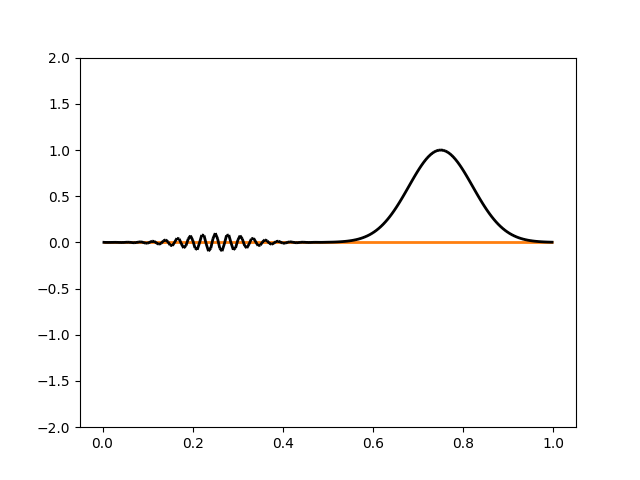

In [15]:
# check if initial conditions actually got applied
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
axes.set_ylim((-2., 2.))
plot(u_n, axes=axes, color='C1')
plot(p_n, axes=axes)

In [16]:
# fast part of rhs, to be integrated implicitly 
def ff(U_n,c_s):
    return as_vector([c_s*U_n.sub(1).dx(0),c_s*U_n.sub(0).dx(0)])

# slow part of rhs, to be integrated explicitly
def fs(U_n,U):
    return as_vector([U*U_n.sub(0).dx(0),U*U_n.sub(1).dx(0)])

f_fast = ff(U_n,c_s)
f_slow = fs(U_n,U)

In [17]:
F = (inner((U_n1 - U_n)/dt,v) + inner(f_fast,v) + inner(f_slow,v))*dx

In [18]:
problem = NonlinearVariationalProblem(F, U_n1)
solver = NonlinearVariationalSolver(problem,nest=False, solver_parameters={'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu'})#{"ksp_type": "preonly", "pc_type": "ilu"})
# store results in here
results = [Function(U_n)] #{'mat_type': 'aij',
    #'ksp_type': 'preonly',
    #'pc_type': 'lu'}

In [19]:
# try to integrate
t = 0
t_end = 0.1
while t <= t_end:
    solver.solve()
    U_n.assign(U_n1)
    results.append(Function(U_n))
    t += dt

0
0.0016666666666666668
0.0033333333333333335
0.005
0.006666666666666667
0.008333333333333333
0.01
0.011666666666666667
0.013333333333333334
0.015000000000000001
0.016666666666666666
0.018333333333333333
0.02
0.021666666666666667
0.023333333333333334
0.025
0.02666666666666667
0.028333333333333335
0.030000000000000002
0.03166666666666667
0.03333333333333333
0.034999999999999996
0.03666666666666666
0.03833333333333332
0.03999999999999999
0.04166666666666665
0.043333333333333314
0.04499999999999998
0.04666666666666664
0.048333333333333305
0.04999999999999997
0.05166666666666663
0.053333333333333295
0.05499999999999996
0.05666666666666662
0.058333333333333286
0.05999999999999995
0.06166666666666661
0.06333333333333328
0.06499999999999995
0.06666666666666661
0.06833333333333327
0.06999999999999994
0.0716666666666666
0.07333333333333326
0.07499999999999993
0.07666666666666659
0.07833333333333325
0.07999999999999992
0.08166666666666658
0.08333333333333325
0.08499999999999991
0.086666666666666

<IPython.core.display.Javascript object>


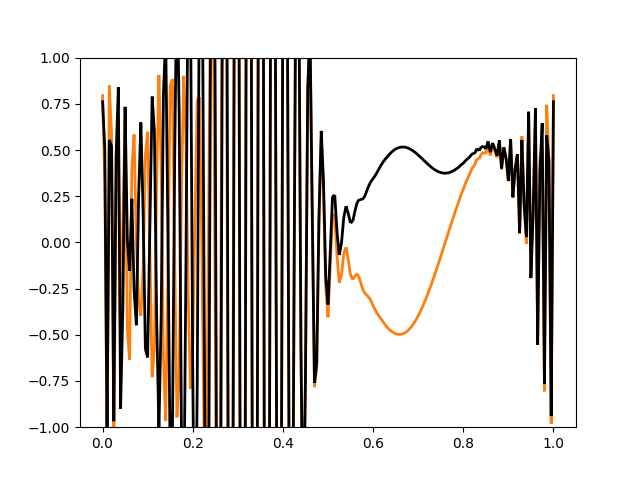

/Users/jf/Firedrake/firedrake/src/firedrake/firedrake/plot.py:805: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = matplotlib.patches.PathPatch(path, **kwargs)


In [20]:
fig, axes = plt.subplots()
axes.set_ylim((-2., 2.))
plot(u_n, axes=axes, color='C1')
plot(p_n, axes=axes)

In [21]:
# NBVAL_IGNORE_OUTPUT
from matplotlib.animation import FuncAnimation

def animate(U_n):
    u_n, p_n = U_n.split()
    axes.clear()
    firedrake.plot(u_n, axes=axes,color='C1')
    firedrake.plot(p_n, axes=axes)
    axes.set_ylim((-1., 1.))

interval = 4e3 * float(dt)
animation = FuncAnimation(fig, animate, frames=results, interval=interval)

from IPython.display import HTML
HTML(animation.to_jshtml())

/Users/jf/Firedrake/firedrake/src/firedrake/firedrake/plot.py:805: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch = matplotlib.patches.PathPatch(path, **kwargs)
